### Purpose

The low liquidity trading team wants a better idea of the volatility capture associated with the the market making agreements they have which involve an option component.

The purpose of this notebook is to give a framework for computing the realized volatitliy of the markets LLT both quote on and have a SLA with an option component.

The granularity of the realized volatility is customizable in the notebook but the team has settled on 15 minute intervals and as such the notebook is parameterised in this way.


inputs:<br />
exchange - A string representing the exchange we want trade data for e.g. "bitfinex".<br />
base - A string representing the base currency we want trade data from e.g. "ccd".<br />
quotes - A list of strings representing the quote currency we want trade data for e.g. ["usd", "usdt", "btc"].<br />
instrument_type - A string representing the instrument type we want data for e.g. "spot".<br />
minutes - An integer representing the minutes window over which resampling occurs for the volatility metric in this notebook set to 15.<br />
tardis_instruments - A table in clickhouse which contains a mapping from tardis instrument ids to instrument ids this table must contain the instruemnt being examined in the notebook.<br />
llt_option_terms - A table in clickhouse which contains all option terms both past and present. For the symbol the user is interested in there must be an option in this table.<br />
tardis_publictrades - A table in clickhouse which contains tardis trade data. For the symbols and options you are interested in analyzing this data must be avalible.<br />  


outputs:<br />
The LLTRealizedVolatility class method display_volatility returns a pandas dataframe that shows the realized volatility for the specified exchange, base, quote, instrument_type combination over the duration of the relevant options given in the llt_option_terms clickhouse table.<br />
The LLTRealizedVolatility class method vol_graphing displays a plot of the realized volatility for a specified exchange, base, quote, instrument_type combination over a given time window.

### Methodology: 

Same methodology as that in the realized_volatility study is used here. It is summarized as follows:

Realized volatility is defined as:

\begin{equation}
v(t_i) = v\left(\Delta t, n, p; t_i \right) = \left[\frac{1}{n-1}\sum^n_{j=1}\lvert r\left(\Delta t; t_{i-n+j} \right) \lvert^p \right]^{1/p}
\end{equation}

* The number of return observations is $n$
* There are two time intervals, the return interval $\Delta t$, and the size of the total sample $n \Delta t$ 
* Regularly spaced returns, $r(t_i)$, are given by the equation:

\begin{equation}
r(t_i) = r(\Delta t; t_i) = x(t_i) - x(t_i - \Delta t)
\end{equation}

where $x(t_i)$ is an homogeneous sequence of logarithmic prices and $\Delta t$ is a time interval of fixed size.

The exponent $p$ is often set to $2$ so that $v^2$ represents the variance of returns about zero, and the volatility definition can be rewritten as:

\begin{equation}
v(t_i) = \sqrt{\frac{\sum_{i=1}^n (r(t_i))^2}{n - 1}}
\end{equation}


One can define annualized realized volatility as: 

\begin{equation}
v_{ann} = \sqrt{\frac{1year}{\Delta t}}v
\end{equation}

### Implementation: 

In [2]:
import pandas as pd
import numpy as np
from clickhouse_driver import Client
import seaborn as sns
import matplotlib.pyplot as plt

# display package
from IPython.display import display, HTML, Markdown
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
class LLTRealizedVolatility():
    
    def __init__(self):
        
        # getting the clickhouse client
        try:
            # case running in an aws instance
            if socket.gethostbyaddr(socket.gethostname())[0].split('.')[1] == 'us-east-2':
                self.host_ip = '172.31.9.89'
        
            # case running on a local instance
            else:
                self.host_ip = '3.145.11.135'
        
        except:
            # case running on a local instance
            self.host_ip = '3.145.11.135'
        
        self.client = Client(host=self.host_ip,
                             port='9000',
                             database='test',
                             user='default',
                             compression=True,
                             connect_timeout=500_000,
                             send_receive_timeout=500_000,
                             sync_request_timeout=500_000,
                             settings={'use_numpy': True}
                             )
        
        # loading in the option terms from the clickhouse
        query = '''
            select *
            from
            test.llt_option_terms
            '''
        col = [
            'name',
            'option_size',
            'base_currency',
            'quote_currency',
            'strike',
            'start_date',
            'end_date'
            ]
        
        ot = self.client.execute(query)
        self.ot = pd.DataFrame(ot, columns=col)
        # cleaning the option terms data
        self.ot = self.ot[self.ot.start_date != '']
        self.ot = self.ot[self.ot.end_date != '']
        self.ot['start_date'] = pd.to_datetime(self.ot.start_date.str.strip(), format='%d/%m/%Y')
        self.ot['end_date'] = pd.to_datetime(self.ot.end_date.str.strip(), format='%d/%m/%Y')
        
        # loading in the tardis instruments table
        query = f'''
        select *
        from
        test.tardis_instruments
        '''
        
        cols = [
            'instrument_id',
            'exchange',
            'symbol',
            'base',
            'quote',
            'instrument_type',
            'tardis_instrument_id',
            'tardis_exchange',
            'tardis_symbol'
        ]
        
        self.instruments = pd.DataFrame(self.client.execute(query), columns = cols)
        
        # list of usd equivilent stablecoins
        self.usd_stables = ['usdt', 'usdc', 'busd']
        
        # setting seaborn plotting theme and figure size
        sns.set_theme(style="darkgrid")
        sns.set(rc={'figure.figsize':(20,4)})
        
    def get_trades(self, exchange: str, base: str, quotes: [], instrument_type: str):
        """
        Pulls in the relevent trades from the tardis_publictrades table.
        
        Parameters
        -------
        exchange - A string representing the exchange we want trade data for e.g. "bitfinex".
        base - A string representing the base currency we want trade data from e.g. "ccd".
        quotes - A list of strings representing the quote currency we want trade data for e.g. ["usd", "usdt", "btc"].
        instrument_type - A string representing the instrument type we want data for e.g. "spot".
        
        Returns
        -------
        trades - A Pandas dataframe of the trade data available in the tardis_publictrades table.
        """
        
        # generating the tardis instrument ids
        tardis_instrument_ids = []
        for quote in quotes:
            tardis_instrument_ids.append(f'{exchange}_{base}_{quote}_{instrument_type}')
        
        # getting the instrument id associated with these tardis instrument ids
        instruments_filt = self.instruments[self.instruments.tardis_instrument_id.isin(tardis_instrument_ids)]
        instrument_ids = instruments_filt.instrument_id.to_list()
        stingified_instrument_ids = []
        for instument in instrument_ids:
            stingified_instrument_ids.append("'" + instument + "'")

        # getting the relevent trade data
        query = f'''
        select *
        from
        test.tardis_publictrades
        where
        instrument_id in ({', '.join(stingified_instrument_ids)})
        '''
        
        cols = [
            'id',
            'instrument_id',
            'recieved_ts',
            'exchange_ts',
            'price',
            'amount',
            'side'
        ]
        
        trades = pd.DataFrame(self.client.execute(query), columns = cols)
        
        # cleaning the trade data
        trades['price'] = trades.price.astype(float)
        trades['amount'] = trades.amount.astype(float)
        trades['side'] = trades.side.astype(int)
        trades['recieved_ts'] = pd.to_datetime(trades.recieved_ts.astype('int64'), unit = 'us')
        trades['exchange_ts'] = pd.to_datetime(trades.exchange_ts.astype('int64'), unit = 'us')
        trades.sort_values('recieved_ts', inplace=True)
        trades.set_index('recieved_ts', inplace = True)
        
        return trades
    
    def preprocess(self, base: str, quotes: []):
        """
        Pre processes the option terms data for the markets we are interested in. Specifically, selects only the option terms
        which are relevant for the base currency we are interested in. Will then also check to see if within the relevant option
        terms there is an option with a quote currency which is USD and within the quotes argument there is a value which
        is a usd stable coin as defined by self.usd_stables. If this is the case for each value of usd_stable in the quotes 
        parameter the option values with a quote currency which is USD are duplicated and the quote currency replaced with 
        the relevant usd_stable value. The logic being that in the case of this analysis I assume usd stable coins are equivilent
        to USD. As such if we have say a CCDUSD option we would be interested in the realized volatility not only on CCDUSD but
        also on say CCDUSDT.
        
        Parameters
        -------
        base - A string representing the base currency we want trade data from e.g. "ccd".
        quotes - A list of strings representing the quote currency we want trade data for e.g. ["usd", "usdt", "btc"].
        
        Returns
        -------
        ot_filt - The preprocessed option terms data.
        """
        
        # selecting option term data that is relevent for the market we are examining
        ot_filt = self.ot[(self.ot.base_currency.str.lower() == base) & (self.ot.quote_currency.str.lower().isin(quotes))]
        
        # checks for case of USD option and usd stablecoin markets
        duplicates = []
        for symbol in self.usd_stables:
            if symbol in quotes:
                duplicates.append(symbol)
                
        # case of USD option and usd stablecoin markets adds rows to ot_filt for these markets
        if ((ot_filt.quote_currency == 'USD').count() > 0) and (len(duplicates) > 0):
            
            additions = []
            for stable in duplicates:
                
                dup = ot_filt[ot_filt.quote_currency == 'USD'].copy()
                dup['quote_currency'] = stable.upper()
                additions.append(dup)
                
            additions.append(ot_filt)
            ot_filt = pd.concat(additions)
            ot_filt.sort_values(['start_date', 'quote_currency'], ascending=True, inplace=True)
            ot_filt.reset_index(inplace=True, drop=True)
            
        return ot_filt
    
    def generate_volatility(self, trades: pd.DataFrame(), ot_filt: pd.DataFrame(), minutes: int):
        """
        Generates the realized volatility statistics for the different options.
        
        Parameters
        -------
        trades - Pandas dataframe of all relevent tardis trades.
        ot_filt - The preprosessed options terms dataframe.
        minutes - The minutes window over which resampling occurs for the volatility metric.
        
        Returns
        -------
        vol_stats - A Pandas dataframe of the realized volatitliy statistics.
        """
        
        # holds the realized vol numbers
        volatility = []
        # looping through the relevant options data
        for start_date, end_date, base, quote in zip(ot_filt['start_date'], ot_filt['end_date'], ot_filt['base_currency'], ot_filt['quote_currency']):
            
            # filtering for the relevant market for this option
            symbol = (base + '_' + quote).lower()
            df_filt = trades[trades.instrument_id.str.contains(symbol)&(trades.index>=start_date)&(trades.index<=end_date)].copy()
            # deletes duplicates based on recieved ts taking the result with the lowest id and then resamples using a time window given by minutes
            # linear interpolation then used to populate the sparce dataframe of prices
            df_filt = df_filt[~df_filt.index.duplicated()][['price']].resample(f'{minutes}T').first().ffill(limit=1).interpolate('linear')
            # returns computed
            df_filt['return'] = (df_filt.price.diff()/df_filt.price.shift(1))
            # volatility is computed and annualised
            volatility.append(np.sqrt((df_filt['return']**2).sum()/(df_filt[~df_filt['return'].isna()].shape[0] - 1))*np.sqrt(365*24*60/minutes))
            
        ot_filt['realized_volatility'] = volatility
        
        return ot_filt[['base_currency', 'quote_currency', 'start_date', 'end_date', 'realized_volatility']]
    
    def display_volatility(self, exchange: str, base: str, quotes: [], instrument_type: str, minutes: int):
        """
        Convenient wrapper to call methods in correct order to generate the realized vol
        
        Parameters
        -------
        exchange - A string representing the exchange we want trade data for e.g. "bitfinex".
        base - A string representing the base currency we want trade data from e.g. "ccd".
        quotes - A list of strings representing the quote currency we want trade data for e.g. ["usd", "usdt", "btc"].
        instrument_type - A string representing the instrument type we want data for e.g. "spot".
        minutes - The minutes window over which resampling occurs for the volatility metric.
        
        Returns
        -------
        vol_stats - The output of the generate_volatility method.
        """
        
        display(Markdown(f"### Data generated for: {exchange}"))
        trades = self.get_trades(exchange, base, quotes, instrument_type)
        ot_filt = self.preprocess(base, quotes)
        vol_stats = self.generate_volatility(trades, ot_filt, minutes)
        
        display(vol_stats)
        
        return vol_stats
        
    def vol_graphing(self, exchange: str, base: str, quote: str, instrument_type: str, minutes: int, window: int,
                     start: str = None, end: str = None):
        """
        Generates a plot of the rolling volatility
        
        Parameters
        -------
        exchange - A string representing the exchange we want trade data for e.g. "bitfinex".
        base - A string representing the base currency we want trade data from e.g. "ccd".
        quotes - A list of strings representing the quote currency we want trade data for e.g. ["usd", "usdt", "btc"].
        instrument_type - A string representing the instrument type we want data for e.g. "spot".
        minutes - The minutes window over which resampling occurs for the volatility metric.
        window - The size of the rolling window being used.
        start - the start timestamp to plot from in the form "YYYY-MM-DD".
        end - the end timestamp to stop plotting from in the form "YYYY-MM-DD".
        
        Returns
        -------
        None
        """
        
        # gets the relevant trades
        trades = self.get_trades(exchange, base, [quote], instrument_type)
        # adjust for the relevant time window
        if start:
            trades = trades[trades.index >= start]
        if end:
            trades = trades[trades.index <= end]
        
        # deletes duplicates based on recieved ts taking the result with the lowest id and then resamples using a time window given by minutes
        # linear interpolation then used to populate the sparce dataframe of prices
        rolling = trades[~trades.index.duplicated()][['price']].resample(f'{minutes}T').first().ffill(limit=1).interpolate('linear')
        rolling['returns'] = rolling.price.diff()/rolling.price.shift(1)
        rolling['returns_squared'] = rolling.returns**2
        rolling['Realized Volatility'] = rolling['returns_squared'].rolling(window).sum()/(window - 1)
        
        # scaling the realized volatility
        rolling['Realized Volatility'] = rolling['Realized Volatility'].pow(1./2)*np.sqrt(365*24*60/minutes)
        # generating a plotly figure
        sns.lineplot(x = 'recieved_ts', y = 'Realized Volatility', data = rolling.reset_index()).set(title=f'Realized volatility for {exchange}: {base}{quote}')
        plt.show()
        
        return

### Generate Realized Volatility

In [4]:
# Parameters
exchange = 'bitfinex'
base = 'ccd'
quotes = ['usd', 'usdt', 'btc']
instrument_type = 'spot'
minutes = 15

In [5]:
lltrv = LLTRealizedVolatility()
vol_stats = lltrv.display_volatility(exchange, base, quotes, instrument_type, minutes)

### Data generated for: bitfinex

,base_currency,quote_currency,start_date,end_date,realized_volatility
0,CCD,BTC,2022-02-10,2022-08-10,1.334808
1,CCD,USD,2022-02-11,2022-08-11,1.042707
2,CCD,USDT,2022-02-11,2022-08-11,1.021907
3,CCD,BTC,2022-08-10,2023-02-10,0.798319
4,CCD,USD,2022-08-11,2023-02-11,0.713344
5,CCD,USDT,2022-08-11,2023-02-11,0.699217
6,CCD,BTC,2023-02-10,2023-08-10,0.837756
7,CCD,USD,2023-02-11,2023-08-11,1.050009
8,CCD,USDT,2023-02-11,2023-08-11,1.061099


### Generate Graphing

In [6]:
# Graphing specific parameters
quote = 'usdt'
window = 4
start = '2022-10-01'
end = '2023-02-01'

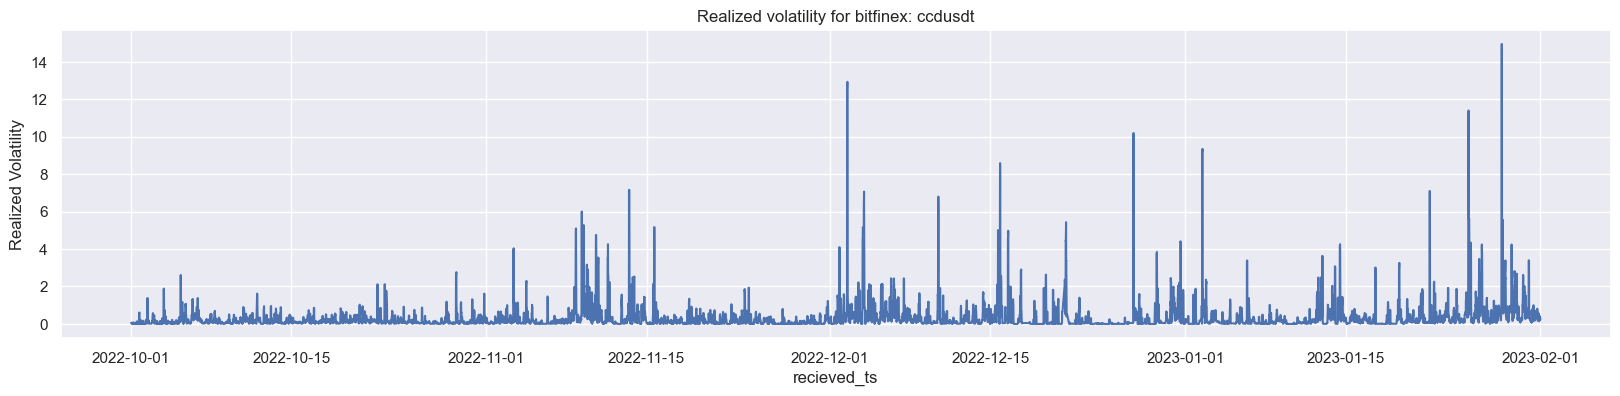

In [7]:
lltrv.vol_graphing(exchange, base, quote, instrument_type, minutes, window,start, end)